In [1]:
from scipy.ndimage import label

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from numba import njit

In [3]:
@njit
def glauber(s = np.array, hi = np.array, N = int):
    '''
    Runs the Glauber algorithm N times

    Input
    _____
    s : ndarray
        2D array with -1 for water and +1 for ice

    hi : ndarray
        2D array (same size as s) with standard normaly distributed values for ice / snow topography

    Output
    ______
    s : ndarray
        2D array with -1 for water and +1 for ice

    sums : ndarray
        array with the sum of s every 1_000_000 iterations 
    '''


    indices = np.arange(1, len(s)-1)
    sums = np.zeros(int(N/1_000_000))

    for i in range(N):
        x = np.random.choice(indices)
        y = np.random.choice(indices)

        sum_neighbors = s[x-1,y] + s[x+1,y] + s[x,y-1] + s[x,y+1]

        if sum_neighbors > 0:
            s[x,y] = +1
        elif sum_neighbors < 0:
            s[x,y] = -1
        else:
            if hi[x,y] >= 0:
                s[x,y] = +1
            else:
                s[x,y] = -1

        if (i%1_000_000) == 0:
            sums[int(i/1_000_000)] = np.sum(s) 
    
    return s, sums

In [4]:
# make a color map of fixed colors
cmap = colors.ListedColormap(['blue', 'white'])
bounds=[-100,0,100]
norm = colors.BoundaryNorm(bounds, cmap.N)

In [51]:
F_in = 0.48
size = 1000

# make random ice water configuration with F_in as fraction of water
s = np.ones(size**2)
s[:int(F_in * size**2)] = -1
np.random.shuffle(s)

s = s.reshape((size,size))
s[[0,-1],:] = 1
s[:,[0,-1]] = 1

In [52]:
# plt.imshow(s, cmap=cmap, norm=norm)

In [53]:
s_copy = s.copy()

In [54]:
# make random snowheight raster
hi = np.random.normal(loc = 0, scale = 1, size = (size, size))
#hi[300:310,:] = 5

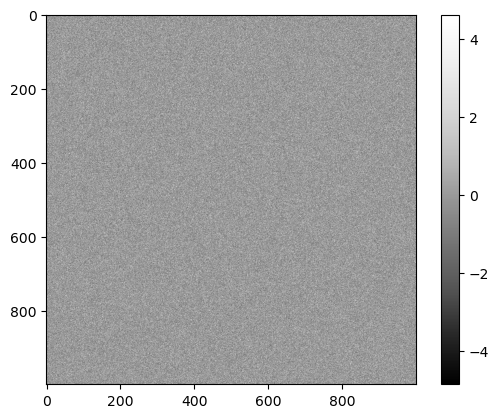

In [55]:
plt.imshow(hi, cmap= 'Greys_r')
plt.colorbar()

In [56]:
# run algorithm till stable state
ponds, sums = glauber(s, hi, 15_000_000)

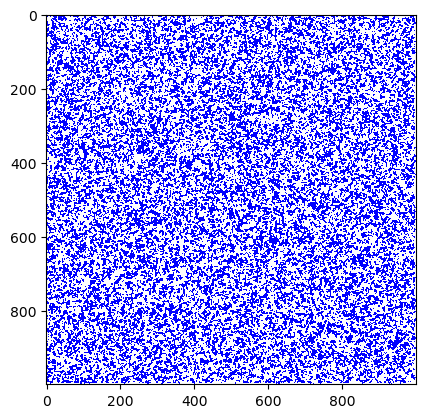

In [57]:
# plot ponds
plt.imshow(ponds, cmap=cmap, norm=norm)

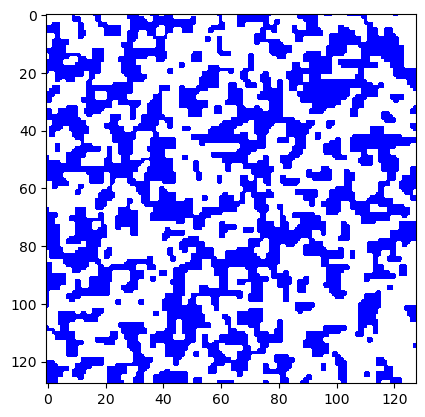

In [58]:
# zoom in
plt.imshow(ponds[100:228,100:228], cmap=cmap, norm=norm)

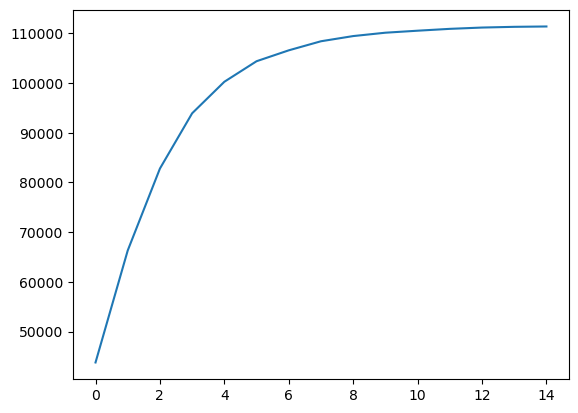

In [59]:
# check for stable state
plt.plot(sums)

In [60]:
# from pylab import *
from scipy.ndimage import label

def perim_area(ponds, pond_val = -1, ice_val = 1):
    '''
    Calculates the area and the perimeter of the meltpods

    Arguments:
        ponds -- 2D ndarray

    Keyword Arguments:
        pond_val -- value indicating that cell is part of a melt pond (default: {-1})
        ice_val --  value indicating that cell is ice (default: {1})

    Returns:
        areas -- 1D ndarray with the area of each melt pond
        perimeters -- 1D ndarray with the perimeter of each melt pond
    '''

    # get the pond clusters
    pond_clusters, _ = label(np.where((ponds) == pond_val, 1, 0))

    clusters = np.unique(pond_clusters)[1:]
    areas = np.zeros(len(clusters))
    perimeters = np.zeros(len(clusters))
    print(len(clusters))
    for i, id in enumerate(clusters):
        areas[i] = np.sum(pond_clusters == id)

        # get the total number of neighboring cells for each cluster
        for cell in np.transpose(np.nonzero(pond_clusters == id)):
            row, col = cell

            perimeters[i] += np.sum(np.array([
                        ponds[row+1, col] == ice_val,
                        ponds[row-1, col] == ice_val,
                        ponds[row, col+1] == ice_val,
                        ponds[row, col-1] == ice_val,
                    ]))



    return areas, perimeters

3350


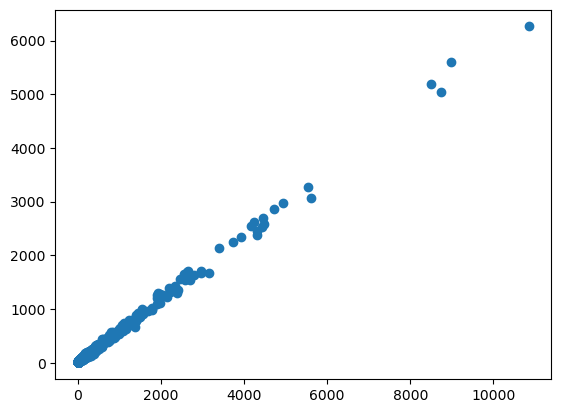

In [61]:
areas, perimeters = perim_area(ponds, pond_val = -1, ice_val = 1)

plt.scatter(areas, perimeters)